In [43]:
import pandas as pd
import datetime as dt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import sqlalchemy as db

from sqlalchemy import create_engine

In [2]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

def get_data_parse_dt(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url, parse_dates=[['DATE','TIME']], keep_date_col=True))
    return pd.concat(dfs)

def get_counts_entries(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

def get_counts_exits(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["EXITS"], row["PREV_EXITS"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

def game_check(time):
    # Function to find turnstile data in window of travel to games
    a, b, c, d = "18", "19", "20", "21"
    if time.startswith(a):
        return True
    elif time.startswith(b):
        return True
    elif time.startswith(c):
        return True
    elif time.startswith(d):
        return True
    else:
        return False
    
def date_edit(date):
    x = date[0:5]
    return x


week_nums = [190504, 190511, 190518, 190601, 190615, 190622, 190629, 190713, 
            190720, 190803, 190817, 190824]


# sample of data to test code on
# week_nums = [190713, 190720, 190803, 190817]

turnstiles_df = get_data_parse_dt(week_nums)
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]

In [3]:
turnstiles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2480829 entries, 0 to 205668
Data columns (total 12 columns):
 #   Column     Dtype         
---  ------     -----         
 0   DATE_TIME  datetime64[ns]
 1   C/A        object        
 2   UNIT       object        
 3   SCP        object        
 4   STATION    object        
 5   LINENAME   object        
 6   DIVISION   object        
 7   DATE       object        
 8   TIME       object        
 9   DESC       object        
 10  ENTRIES    int64         
 11  EXITS      int64         
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 246.1+ MB


In [4]:
yankee_games = pd.read_csv("yankee-games.csv")

In [5]:
'''
# creating/calling a database from SQL to Python
engine = create_engine('sqlite:///yankee_games.db', echo=False)

# save raw data to SQL
yankee_games.to_sql('yankee_games', con=engine)
turnstiles_df.to_sql('turnstiles_df', con=engine)
'''

"\n# creating/calling a database from SQL to Python\nengine = create_engine('sqlite:///yankee_games.db', echo=False)\n\n# save raw data to SQL\nyankee_games.to_sql('yankee_games', con=engine)\nturnstiles_df.to_sql('turnstiles_df', con=engine)\n"

In [8]:
# using sqlalchemy to call SQL db from Python
engine = create_engine('sqlite:///yankee_games.db')
df = pd.read_sql('select * from turnstiles_df limit 1', engine)
df

,index,DATE_TIME,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS
0,208565,2019-08-16 21:00:00.000000,TRAM2,R469,00-05-01,RIT-ROOSEVELT,08/16/2019,21:00:00,5554,386


In [9]:
# example #2
data_from_sql = pd.read_sql('SELECT * FROM yankee_games', con=engine)
data_from_sql

,index,game_date,game_time
0,0,05/06/2019,18:30:00
1,1,05/07/2019,18:30:00
2,2,05/08/2019,18:30:00
3,3,05/09/2019,18:30:00
4,4,05/17/2019,19:00:00
5,5,05/28/2019,18:30:00
6,6,05/31/2019,19:00:00
7,7,06/11/2019,19:00:00
8,8,06/17/2019,19:00:00
9,9,06/18/2019,19:00:00


In [10]:
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

turnstiles_df = turnstiles_df.drop(["DIVISION", "LINENAME", "DESC"], axis=1, errors="ignore")

In [11]:
my_turnstiles = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME", "DATE", "TIME"],as_index=False)
                        .EXITS.first())

my_turnstiles.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,DATE,TIME,EXITS
0,A002,R051,02-00-00,59 ST,2019-04-27 00:00:00,04/27/2019,00:00:00,2384833
1,A002,R051,02-00-00,59 ST,2019-04-27 04:00:00,04/27/2019,04:00:00,2384840
2,A002,R051,02-00-00,59 ST,2019-04-27 08:00:00,04/27/2019,08:00:00,2384875
3,A002,R051,02-00-00,59 ST,2019-04-27 12:00:00,04/27/2019,12:00:00,2384951
4,A002,R051,02-00-00,59 ST,2019-04-27 16:00:00,04/27/2019,16:00:00,2385020


In [12]:
my_turnstiles[["PREV_DATE_TIME", "PREV_EXITS"]] = (my_turnstiles
                                                    .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE_TIME", "EXITS"]
                                                    .apply(lambda grp: grp.shift(1)))
my_turnstiles.head()

C:\Users\Billy\AppData\Local\Temp/ipykernel_11740/1079307952.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  my_turnstiles[["PREV_DATE_TIME", "PREV_EXITS"]] = (my_turnstiles


,C/A,UNIT,SCP,STATION,DATE_TIME,DATE,TIME,EXITS,PREV_DATE_TIME,PREV_EXITS
0,A002,R051,02-00-00,59 ST,2019-04-27 00:00:00,04/27/2019,00:00:00,2384833,NaT,NaN
1,A002,R051,02-00-00,59 ST,2019-04-27 04:00:00,04/27/2019,04:00:00,2384840,2019-04-27 00:00:00,2384833.0
2,A002,R051,02-00-00,59 ST,2019-04-27 08:00:00,04/27/2019,08:00:00,2384875,2019-04-27 04:00:00,2384840.0
3,A002,R051,02-00-00,59 ST,2019-04-27 12:00:00,04/27/2019,12:00:00,2384951,2019-04-27 08:00:00,2384875.0
4,A002,R051,02-00-00,59 ST,2019-04-27 16:00:00,04/27/2019,16:00:00,2385020,2019-04-27 12:00:00,2384951.0


In [13]:
# my_turnstiles["REAL_ENTRIES"] = my_turnstiles.apply(get_counts_entries, axis=1, max_counter=1000000)
my_turnstiles["REAL_EXITS"] = my_turnstiles.apply(get_counts_exits, axis=1, max_counter=1000000)

43 1109611.0
151 1663045.0
1541 1830961.0
23 2256389.0
828 1252734.0
7 16906904.0
650 1045591.0
1850345261 8696067.0
3 702628996.0
17 14611990.0
0 4745860.0
3430095 8440581.0
4745860 2455688.0
8440589 1962487.0
2265 6666300.0
1780219 4759346.0
4 5978882.0
0 19884082.0
1105 10786706.0
20365 7550494.0
910 2816760.0
2405 6365661.0
2422 2576797.0
10926 10178232.0
335091288 2643003.0
6 1932161.0
207 4576770.0
65543 1928559.0
1933095 65543.0
66 3130175.0
14948 8475199.0
569323232 9972009.0
5216 3349081.0
318790443 1305497.0
114 9433893.0
112 2840229.0
2 167841841.0
1828766039 7176121.0
17 1789860.0
604045276 2396562.0
16785950 71903.0
4533 1984069.0
59 2358031.0
302 2844689.0
9 3657233.0
12 7146400.0
1765 5003411.0
1158 7279490.0
205 369533236.0
98 2893961.0
13 2882732.0
6449 5141573.0
57 5013382.0
620 1691805.0
687875482 2748237.0
63 2042934.0
63 1457383.0
460 1411633.0
94 1168621.0
32 1349684.0
109 1911650.0
106 2846892.0
0 1101959.0
1202 2612408.0
773 2013604.0
1278 1879841.0
173 2928187.

In [14]:
my_turnstiles.head()
my_turnstiles.reset_index()


,index,C/A,UNIT,SCP,STATION,DATE_TIME,DATE,TIME,EXITS,PREV_DATE_TIME,PREV_EXITS,REAL_EXITS
0,0,A002,R051,02-00-00,59 ST,2019-04-27 00:00:00,04/27/2019,00:00:00,2384833,NaT,NaN,NaN
1,1,A002,R051,02-00-00,59 ST,2019-04-27 04:00:00,04/27/2019,04:00:00,2384840,2019-04-27 00:00:00,2384833.0,7.0
2,2,A002,R051,02-00-00,59 ST,2019-04-27 08:00:00,04/27/2019,08:00:00,2384875,2019-04-27 04:00:00,2384840.0,35.0
3,3,A002,R051,02-00-00,59 ST,2019-04-27 12:00:00,04/27/2019,12:00:00,2384951,2019-04-27 08:00:00,2384875.0,76.0
4,4,A002,R051,02-00-00,59 ST,2019-04-27 16:00:00,04/27/2019,16:00:00,2385020,2019-04-27 12:00:00,2384951.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2480780,2480780,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-08-23 05:00:00,08/23/2019,05:00:00,386,2019-08-23 01:00:00,386.0,0.0
2480781,2480781,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-08-23 09:00:00,08/23/2019,09:00:00,386,2019-08-23 05:00:00,386.0,0.0
2480782,2480782,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-08-23 13:00:00,08/23/2019,13:00:00,386,2019-08-23 09:00:00,386.0,0.0
2480783,2480783,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-08-23 17:00:00,08/23/2019,17:00:00,386,2019-08-23 13:00:00,386.0,0.0


In [15]:
my_turnstiles['DAY'] = my_turnstiles["DATE_TIME"].dt.dayofweek

my_turnstiles = my_turnstiles.drop(["PREV_DATE_TIME"], axis=1, errors="ignore")

my_turnstiles.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,DATE,TIME,EXITS,PREV_EXITS,REAL_EXITS,DAY
0,A002,R051,02-00-00,59 ST,2019-04-27 00:00:00,04/27/2019,00:00:00,2384833,NaN,NaN,5
1,A002,R051,02-00-00,59 ST,2019-04-27 04:00:00,04/27/2019,04:00:00,2384840,2384833.0,7.0,5
2,A002,R051,02-00-00,59 ST,2019-04-27 08:00:00,04/27/2019,08:00:00,2384875,2384840.0,35.0,5
3,A002,R051,02-00-00,59 ST,2019-04-27 12:00:00,04/27/2019,12:00:00,2384951,2384875.0,76.0,5
4,A002,R051,02-00-00,59 ST,2019-04-27 16:00:00,04/27/2019,16:00:00,2385020,2384951.0,69.0,5


In [16]:
my_turnstiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2480785 entries, 0 to 2480784
Data columns (total 11 columns):
 #   Column      Dtype         
---  ------      -----         
 0   C/A         object        
 1   UNIT        object        
 2   SCP         object        
 3   STATION     object        
 4   DATE_TIME   datetime64[ns]
 5   DATE        object        
 6   TIME        object        
 7   EXITS       int64         
 8   PREV_EXITS  float64       
 9   REAL_EXITS  float64       
 10  DAY         int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 208.2+ MB


In [17]:
week_days = my_turnstiles[my_turnstiles.DAY < 5]

week_days['game_check'] = week_days["TIME"].apply(game_check)


C:\Users\Billy\AppData\Local\Temp/ipykernel_11740/2768888761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_days['game_check'] = week_days["TIME"].apply(game_check)


In [18]:
game_window = week_days[week_days['game_check'] == True]


game_window.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293727 entries, 17 to 2480784
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   C/A         293727 non-null  object        
 1   UNIT        293727 non-null  object        
 2   SCP         293727 non-null  object        
 3   STATION     293727 non-null  object        
 4   DATE_TIME   293727 non-null  datetime64[ns]
 5   DATE        293727 non-null  object        
 6   TIME        293727 non-null  object        
 7   EXITS       293727 non-null  int64         
 8   PREV_EXITS  293720 non-null  float64       
 9   REAL_EXITS  293720 non-null  float64       
 10  DAY         293727 non-null  int64         
 11  game_check  293727 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 27.2+ MB


In [19]:
yankee_games.head()

,game_date,game_time
0,05/03/2019,19:00:00
1,05/06/2019,18:30:00
2,05/07/2019,18:30:00
3,05/08/2019,18:30:00
4,05/09/2019,18:30:00


In [20]:
yankee_games_data = pd.merge(game_window, yankee_games, left_on="DATE", right_on="game_date")
yankee_games_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122316 entries, 0 to 122315
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   C/A         122316 non-null  object        
 1   UNIT        122316 non-null  object        
 2   SCP         122316 non-null  object        
 3   STATION     122316 non-null  object        
 4   DATE_TIME   122316 non-null  datetime64[ns]
 5   DATE        122316 non-null  object        
 6   TIME        122316 non-null  object        
 7   EXITS       122316 non-null  int64         
 8   PREV_EXITS  122316 non-null  float64       
 9   REAL_EXITS  122316 non-null  float64       
 10  DAY         122316 non-null  int64         
 11  game_check  122316 non-null  bool          
 12  game_date   122316 non-null  object        
 13  game_time   122316 non-null  object        
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 13.2+ MB


In [21]:
regular_days = game_window[game_window["DATE"].isin(yankee_games_data["game_date"]) == False]

regular_days.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171411 entries, 17 to 2480784
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   C/A         171411 non-null  object        
 1   UNIT        171411 non-null  object        
 2   SCP         171411 non-null  object        
 3   STATION     171411 non-null  object        
 4   DATE_TIME   171411 non-null  datetime64[ns]
 5   DATE        171411 non-null  object        
 6   TIME        171411 non-null  object        
 7   EXITS       171411 non-null  int64         
 8   PREV_EXITS  171404 non-null  float64       
 9   REAL_EXITS  171404 non-null  float64       
 10  DAY         171411 non-null  int64         
 11  game_check  171411 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 15.9+ MB


In [22]:
game_exits = yankee_games_data.groupby(["STATION", "DATE_TIME"])[['REAL_EXITS']].sum().reset_index()

avg_game_exits = game_exits.groupby(["STATION"])[['REAL_EXITS']].mean().reset_index()

avg_game_exits.rename(columns = {"REAL_EXITS": "Avg Game Exits"}, inplace=True)

avg_game_exits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   STATION         378 non-null    object 
 1   Avg Game Exits  378 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.0+ KB


In [23]:
Game_Traffic = avg_game_exits.sort_values(by=['Avg Game Exits'], ascending=False)
Game_Traffic.head(20)

,STATION,Avg Game Exits
232,GRD CNTRL-42 ST,39347.740000
78,50 ST,22134.096154
352,TIMES SQ-42 ST,21942.250000
59,34 ST-HERALD SQ,21781.333333
14,14 ST-UNION SQ,21535.440000
216,FLUSHING-MAIN,19174.480000
61,34 ST-PENN STA,17593.302326
68,42 ST-PORT AUTH,15966.060000
124,ATL AV-BARCLAY,14775.000000
256,JKSN HT-ROOSVLT,14100.440000


In [24]:
regular_exits = regular_days.groupby(["STATION", "DATE_TIME"])[['REAL_EXITS']].sum().reset_index()

avg_regular_exits = regular_exits.groupby(["STATION"])[['REAL_EXITS']].mean().reset_index()

avg_regular_exits.rename(columns = {"REAL_EXITS": "Avg Regular Exits"}, inplace=True)

avg_regular_exits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   STATION            378 non-null    object 
 1   Avg Regular Exits  378 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.0+ KB


In [25]:
compare_df = pd.merge(avg_game_exits, avg_regular_exits, on="STATION")

compare_df["Game Effect"] = compare_df["Avg Game Exits"] - compare_df["Avg Regular Exits"]

compare_df.reset_index()

compare_df.sort_values(by=['Game Effect'], ascending=False, inplace=True)
compare_df.head(10)

,STATION,Avg Game Exits,Avg Regular Exits,Game Effect
232,GRD CNTRL-42 ST,39347.740000,13576.545455,25771.194545
78,50 ST,22134.096154,9687.000000,12447.096154
21,161/YANKEE STAD,12739.640000,4585.342857,8154.297143
117,9TH STREET,3331.788136,261.686391,3070.101745
47,231 ST,3193.880000,582.114286,2611.765714
17,14TH STREET,2431.893701,180.011364,2251.882337
355,TWENTY THIRD ST,6282.218009,4402.949153,1879.268857
6,116 ST,5393.000000,3684.673077,1708.326923
341,SPRING ST,4266.240000,3058.980000,1207.260000
46,23 ST,11028.080000,9960.700000,1067.380000


In [26]:
compare_df.tail(10)

,STATION,Avg Game Exits,Avg Regular Exits,Game Effect
352,TIMES SQ-42 ST,21942.250000,23948.942857,-2006.692857
61,34 ST-PENN STA,17593.302326,19646.900000,-2053.597674
278,METS-WILLETS PT,1025.240000,3182.085714,-2156.845714
176,CATHEDRAL PKWY,2928.480000,5137.428571,-2208.948571
269,LEXINGTON AV/53,4065.714286,6857.685714,-2791.971429
212,EXCHANGE PLACE,239.928934,3208.661058,-2968.732124
251,JAMAICA CENTER,7278.000000,11605.666667,-4327.666667
97,72 ST,7008.140000,13269.242857,-6261.102857
316,PAVONIA/NEWPORT,700.413127,7404.911357,-6704.498230
59,34 ST-HERALD SQ,21781.333333,33919.971429,-12138.638095


In [38]:
compare_df["Game Effect %"] = ((100 * (compare_df["Avg Game Exits"] - compare_df["Avg Regular Exits"])) / 
                               (compare_df["Avg Regular Exits"]))

compare_df.sort_values(by=['Game Effect %'], ascending=False, inplace=True)

compare_df.head(10)

,STATION,Avg Game Exits,Avg Regular Exits,Game Effect,Game Effect %
17,14TH STREET,2431.893701,180.011364,2251.882337,1250.966768
117,9TH STREET,3331.788136,261.686391,3070.101745,1173.198858
47,231 ST,3193.880000,582.114286,2611.765714,448.668892
350,THIRTY ST,366.905747,107.714519,259.191228,240.627941
232,GRD CNTRL-42 ST,39347.740000,13576.545455,25771.194545,189.821443
21,161/YANKEE STAD,12739.640000,4585.342857,8154.297143,177.833968
78,50 ST,22134.096154,9687.000000,12447.096154,128.492786
343,ST. GEORGE,1.120000,0.680851,0.439149,64.500000
167,BROOKLYN BRIDGE,1322.780000,882.510000,440.270000,49.888387
6,116 ST,5393.000000,3684.673077,1708.326923,46.363053


In [27]:
median_game_exits = game_exits.groupby(["STATION"])[['REAL_EXITS']].median().reset_index()
median_game_exits.rename(columns = {"REAL_EXITS": "Median Game Exits"}, inplace=True)

median_regular_exits = regular_exits.groupby(["STATION"])[['REAL_EXITS']].median().reset_index()
median_regular_exits.rename(columns = {"REAL_EXITS": "Median Regular Exits"}, inplace=True)

median_compare_df = pd.merge(median_game_exits, median_regular_exits, on="STATION")

median_compare_df["Game Effect"] = median_compare_df["Median Game Exits"] - median_compare_df["Median Regular Exits"]

median_compare_df.reset_index()

median_compare_df.sort_values(by=['Game Effect'], ascending=False, inplace=True)
median_compare_df.head(10)


,STATION,Median Game Exits,Median Regular Exits,Game Effect
21,161/YANKEE STAD,12621.0,3745.0,8876.0
232,GRD CNTRL-42 ST,19991.5,13110.5,6881.0
68,42 ST-PORT AUTH,14713.5,8379.0,6334.5
110,86 ST,10098.5,7142.0,2956.5
13,14 ST,6645.0,4313.5,2331.5
97,72 ST,5880.5,4247.0,1633.5
167,BROOKLYN BRIDGE,1276.5,15.5,1261.0
182,CHURCH AV,3923.0,2785.0,1138.0
102,77 ST,2598.5,1465.5,1133.0
5,111 ST,1643.0,568.0,1075.0


In [28]:
# shows how most of the high differences in Avg Exits were due to one or more outliers in data

station_231 = game_window[game_window['STATION'] == '231 ST']

station_231_exits = station_231.groupby(["STATION", "DATE_TIME"])[['REAL_EXITS']].sum().reset_index()

station_231_exits_sorted = station_231_exits.sort_values(by=['REAL_EXITS'], ascending=False)
station_231_exits_sorted.head(10)

,STATION,DATE_TIME,REAL_EXITS
53,231 ST,2019-08-15 20:00:00,66095.0
32,231 ST,2019-06-26 20:00:00,914.0
2,231 ST,2019-05-01 20:00:00,681.0
5,231 ST,2019-05-06 20:00:00,673.0
1,231 ST,2019-04-30 20:00:00,665.0
18,231 ST,2019-05-30 20:00:00,659.0
37,231 ST,2019-07-10 20:00:00,647.0
21,231 ST,2019-06-11 20:00:00,643.0
12,231 ST,2019-05-15 20:00:00,642.0
40,231 ST,2019-07-15 20:00:00,640.0


In [29]:
# these spikes corresponded to game days

yank_stad_station = game_window[game_window['STATION'] == '161/YANKEE STAD']

yank_stad_station_exits = yank_stad_station.groupby(["STATION", "DATE"])[['REAL_EXITS']].sum().reset_index()

yank_stad_station_exits.head(20)

,STATION,DATE,REAL_EXITS
0,161/YANKEE STAD,04/29/2019,3779.0
1,161/YANKEE STAD,04/30/2019,3865.0
2,161/YANKEE STAD,05/01/2019,3724.0
3,161/YANKEE STAD,05/02/2019,3811.0
4,161/YANKEE STAD,05/03/2019,11488.0
5,161/YANKEE STAD,05/06/2019,11006.0
6,161/YANKEE STAD,05/07/2019,11398.0
7,161/YANKEE STAD,05/08/2019,12044.0
8,161/YANKEE STAD,05/09/2019,11413.0
9,161/YANKEE STAD,05/10/2019,3569.0


In [30]:
yankee_games.head(8)

,game_date,game_time
0,05/03/2019,19:00:00
1,05/06/2019,18:30:00
2,05/07/2019,18:30:00
3,05/08/2019,18:30:00
4,05/09/2019,18:30:00
5,05/17/2019,19:00:00
6,05/28/2019,18:30:00
7,05/31/2019,19:00:00


Text(0.5, 1.0, 'Daily Exits for 161st Street-Yankee Stadium')

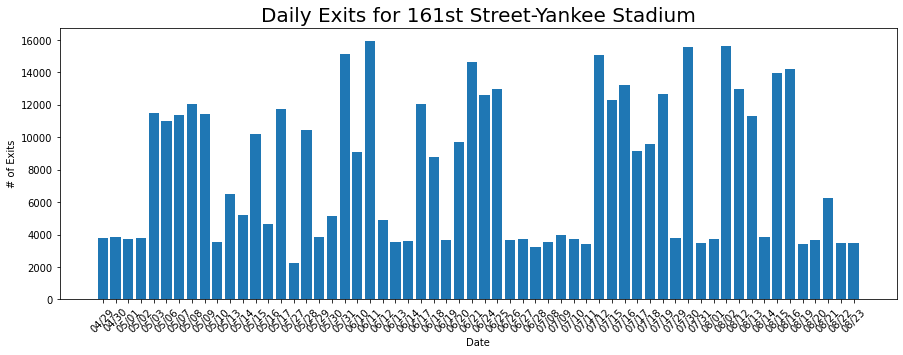

In [31]:
yank_stad_station_exits['Date'] = yank_stad_station_exits['DATE'].apply(date_edit)


x = yank_stad_station_exits['Date']
y = yank_stad_station_exits['REAL_EXITS']


plt.figure(figsize=(15,5))
plt.bar(x,y)
plt.ylabel('# of Exits')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily Exits for 161st Street-Yankee Stadium', fontsize = 20)

# can use to create a .jpg of graph
# plt.savefig('yankee_station_exits_by_day.jpg')

<AxesSubplot:xlabel='Date', ylabel='REAL_EXITS'>

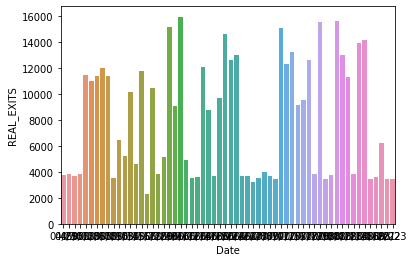

In [46]:
# Seaborn barplot demonstration
sns.barplot(x= 'Date', y = 'REAL_EXITS', data = yank_stad_station_exits)

In [32]:
# grouping station exit data by normal/game day and by day of week

'''
# other stations set up to be plotted to show outlier effect on avg difference
reg_grand_cntrl = regular_exits[regular_exits['STATION'] == 'GRD CNTRL-42 ST']
reg_grand_cntrl['DAY'] = reg_grand_cntrl["DATE_TIME"].dt.dayofweek
reg_grand_cntrl_day_of_week = reg_grand_cntrl.groupby(["STATION", "DAY"])[['REAL_EXITS']].mean().reset_index()

game_grand_cntrl = game_exits[game_exits['STATION'] == 'GRD CNTRL-42 ST']
game_grand_cntrl['DAY'] = game_grand_cntrl["DATE_TIME"].dt.dayofweek
game_grand_cntrl_day_of_week = game_grand_cntrl.groupby(["STATION", "DAY"])[['REAL_EXITS']].mean().reset_index()

reg_50_st = regular_exits[regular_exits['STATION'] == 'GRD CNTRL-42 ST']
reg_50_st['DAY'] = reg_50_st["DATE_TIME"].dt.dayofweek
reg_50_st_day_of_week = reg_50_st.groupby(["STATION", "DAY"])[['REAL_EXITS']].mean().reset_index()

game_50_st = game_exits[game_exits['STATION'] == 'GRD CNTRL-42 ST']
game_50_st['DAY'] = game_50_st["DATE_TIME"].dt.dayofweek
game_50_st_day_of_week = game_50_st.groupby(["STATION", "DAY"])[['REAL_EXITS']].mean().reset_index()
'''

reg_yank_stad_station = regular_exits[regular_exits['STATION'] == '161/YANKEE STAD']
reg_yank_stad_station['DAY'] = reg_yank_stad_station["DATE_TIME"].dt.dayofweek
reg_yank_stad_station_day_of_week = reg_yank_stad_station.groupby(["STATION", "DAY"])[['REAL_EXITS']].mean().reset_index()

game_yank_stad_station = game_exits[game_exits['STATION'] == '161/YANKEE STAD']
game_yank_stad_station['DAY'] = game_yank_stad_station["DATE_TIME"].dt.dayofweek
game_yank_stad_station_day_of_week = game_yank_stad_station.groupby(["STATION", "DAY"])[['REAL_EXITS']].mean().reset_index()



C:\Users\Billy\AppData\Local\Temp/ipykernel_11740/3703758878.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_yank_stad_station['DAY'] = reg_yank_stad_station["DATE_TIME"].dt.dayofweek
C:\Users\Billy\AppData\Local\Temp/ipykernel_11740/3703758878.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_yank_stad_station['DAY'] = game_yank_stad_station["DATE_TIME"].dt.dayofweek


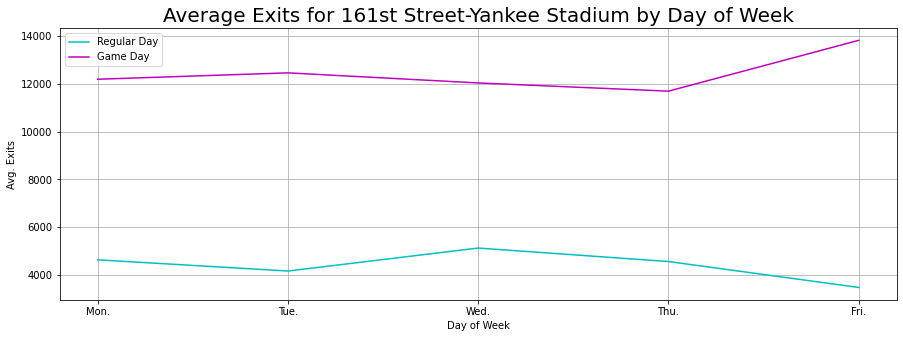

In [33]:
plt.figure(figsize=(15,5))
plt.ylabel('Avg. Exits')
plt.xlabel('Day of Week')
plt.xticks([0, 1, 2, 3, 4], ['Mon.','Tue.','Wed.','Thu.', 'Fri.'])
plt.title('Average Exits for 161st Street-Yankee Stadium by Day of Week', fontsize = 20)
plt.grid()

# other plots also show outlier effect on avg difference
# plt.plot(reg_grand_cntrl_day_of_week['DAY'], reg_grand_cntrl_day_of_week['REAL_EXITS'], color = 'r')
# plt.plot(game_grand_cntrl_day_of_week['DAY'], game_grand_cntrl_day_of_week['REAL_EXITS'], color = 'b')
# plt.plot(reg_50_st_day_of_week['DAY'], reg_50_st_day_of_week['REAL_EXITS'], color = 'r')
# plt.plot(game_50_st_day_of_week['DAY'], game_50_st_day_of_week['REAL_EXITS'], color = 'b')

plt.plot(reg_yank_stad_station_day_of_week['DAY'], reg_yank_stad_station_day_of_week['REAL_EXITS'], color = 'c')
plt.plot(game_yank_stad_station_day_of_week['DAY'], game_yank_stad_station_day_of_week['REAL_EXITS'], color = 'm')
plt.legend(['Regular Day','Game Day'])

# can use to create a .jpg of graph
# plt.savefig('avg_yankee_exits_day_of_week.jpg')

In [39]:
game_yank_stad_station_day_of_week.head()

,STATION,DAY,REAL_EXITS
0,161/YANKEE STAD,0,12199.200000
1,161/YANKEE STAD,1,12466.125000
2,161/YANKEE STAD,2,12044.000000
3,161/YANKEE STAD,3,11699.666667
4,161/YANKEE STAD,4,13827.875000
